# **Respiratory Sound Classification** 
## Based on BiGRU-Attention Network with XGBoost


### Importing Packages

In [1]:
%pip install pyACA

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyACA
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier as XGB
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm


import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import keras.layers as Layers

import warnings
warnings.filterwarnings("ignore")

## 1. **Feature Extraction**
We will be using following features for the classification purpose :
* Short-term Average Zero-crossing Rate
* Spectral Centroid
* Spectral Slope
* Spectral Contrast
* RMS Energy
* Chromaticity
* MFCC

In [3]:
raw_dataset = './raw dataset/'
csv_path = './mldata.csv'
np_dir = './np_arrays/'
final_dataset = './final_dataset/'

f_start = 101
f_end = 639

labels_df = pd.read_csv(csv_path)

In [4]:
FRAME_LENGTH = 1024
HOP_LENGTH = 512

def SpectralSlope(data, sr, hop_length):
    ss = []
    for i in range(0,len(data),512):
        slice = data[i:i+512]
        s = pyACA.FeatureSpectralSlope(slice, f_s=sr)
        ss.append(s*512)
    return np.array(ss)

def grad(arr):
    arr = np.array(arr)
    grad_arr = []
    for i in range(arr.shape[0]):
        grad_arr.append(np.gradient(arr[i]))
    return np.array(grad_arr)

def extract_features(file_path: str, frame_length, hop_length):

    audio_signal, sr = librosa.load(file_path)

    stft = np.abs(librosa.stft(audio_signal))
    mfccs_features = librosa.feature.mfcc(audio_signal, sr=sr, n_mfcc=12)
    # mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    mfccs_grad = grad(mfccs_features)
    all_mfccs = np.concatenate((mfccs_features,mfccs_grad))
    # chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    # contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    zcr = frame_length*(librosa.feature.zero_crossing_rate(audio_signal, frame_length=frame_length, hop_length=hop_length)[0])
    rms = librosa.feature.rms(audio_signal, frame_length=frame_length, hop_length=hop_length)[0]
    spectral_centroid = librosa.feature.spectral_centroid(audio_signal, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    spectral_slope = SpectralSlope(audio_signal, sr, hop_length)

    return [zcr, rms, spectral_centroid, all_mfccs, chroma, contrast, spectral_slope]


Note : 3 cells below are not to be run again as the dataset is already stored in .npz files

In [5]:
# for patient in tqdm(range(f_start,f_end+1), 'Extraction Progress '):
#   file_name = os.path.join(os.path.abspath(raw_dataset)+'/'+str(patient)+'.wav')
#   extracted_arrs = extract_features(file_name,FRAME_LENGTH,HOP_LENGTH)
#   np.savez(np_dir+str(patient)+'.npz',zcr = extracted_arrs[0],rms = extracted_arrs[1],spectral_centroid = extracted_arrs[2],\
#            mfcc = extracted_arrs[3], chroma = extracted_arrs[4],spectral_contrast = extracted_arrs[5], spectral_slope=extracted_arrs[6])

### Creating Final Dataset
> Note : To be run only once

In [6]:
# data_3d = []

# for patient in range(f_start,f_end+1):
#     arrs = np.load(np_dir+str(patient)+'.npz')
#     final = []
#     for i in arrs:
#         f_arr = None
#         if patient==f_start:
#             print(i,arrs[i].shape)
#         if arrs[i].shape[0]<100:
#             for ar in arrs[i]:
#                 f_arr = ar
#                 if f_arr.shape[0]<862:
#                     new_f = np.zeros(862)
#                     for ii in range(f_arr.shape[0]):
#                         new_f[ii] = f_arr[ii]
#                     final.append(new_f)
#                 else:
#                     final.append(f_arr[:862])
#         else:
#             f_arr = arrs[i]
#             if f_arr.shape[0]<862:
#                 new_f = np.zeros(862)
#                 for ii in range(f_arr.shape[0]):
#                     new_f[ii] = f_arr[ii]
#                 final.append(new_f)
#             else:
#                 final.append(f_arr[:862])
    
#     final = np.array(final).T
#     np.save(final_dataset+str(patient)+'.npy',final)
#     data_3d.append(final)

# data_3d = np.array(data_3d)
# df = {'features':data_3d}

zcr (862,)\
rms (862,)\
spectral_centroid (862,)\
mfcc (24, 862)\
chroma (12, 862)\
spectral_contrast (7, 862)\
spectral_slope (862,)

In [7]:
# print(data_3d.shape)

(539, 862, 47)

In [5]:
labels = []

for i in range(len(labels_df)):
    crackles = labels_df['crackles'][i]
    wheezes = labels_df['wheezes'][i]
    if crackles==0 and wheezes==0:
        labels.append(0)
    elif crackles and wheezes:
        labels.append(3)
    elif crackles==0 and wheezes!=0:
        labels.append(2)
    elif crackles!=0 and wheezes==0:
        labels.append(1)
    else:
        labels.append(-1)

labels_df['class'] = labels
labels_df = pd.concat([labels_df['patient'], labels_df['crackles'],labels_df['wheezes'],labels_df['class']], axis=1)
labels_df.to_csv(csv_path)

labels_df.head(10)

,patient,crackles,wheezes,class
0,101,0,11,2
1,102,0,0,0
2,103,0,5,2
3,104,0,2,2
4,105,0,0,0
5,106,0,0,0
6,107,5,0,1
7,108,8,1,3
8,109,10,0,1
9,110,13,0,1


In [6]:
data_3d = []                                                                    # ran ~ 3 min 30 secs

for patient in range(f_start,f_end+1):
    row = np.load(final_dataset+str(patient)+'.npy')
    data_3d.append(row)

df = pd.DataFrame({'patient':labels_df['patient'], 'features':data_3d, 'class':labels_df['class']})
df.head()

,patient,features,class
0,101,"[[0.0, 0.0, 0.0, -445.4117126464844, 0.0, 0.0,...",2
1,102,"[[0.0, 0.09875842928886414, 1049.1760661583844...",0
2,103,"[[6.0, 0.06401204317808151, 659.8168860261126,...",2
3,104,"[[0.0, 0.0844806358218193, 1117.7693469286253,...",2
4,105,"[[0.0, 0.0, 0.0, -424.2092590332031, 0.0, 0.0,...",0


In [7]:
X = np.asarray(data_3d)
Y = np.asarray(labels_df['class'])

X_train, X_test, Y_train, Y_test = tts(X,Y, test_size=0.3, random_state=42)
X_train, X_val, Y_train, Y_val = tts(X_train,Y_train, test_size=0.25, random_state=42)


X_train = np.asarray(X_train)
X_test = np.asarray(X)
Y_test = np.asarray(Y)
X_val = np.asarray(X_val)

In [8]:
OneHot = sklearn.preprocessing.OneHotEncoder()

OneHot.fit(np.reshape(Y_train, (-1,1)))

Y_train_OH = OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()
Y_val_OH = OneHot.transform(np.reshape(Y_val, (-1,1))).toarray()
Y_test_OH = OneHot.transform(np.reshape(Y_test, (-1,1))).toarray()
Y_OH = OneHot.transform(np.reshape(Y, (-1,1))).toarray()

Y_train_OH

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

## **Bi-LSTM Models**

In [9]:
import pydotplus                        # for plotting models
pydotplus.find_graphviz()

{'dot': 'C:\\Program Files (x86)\\Graphviz\\bin\\dot.exe',
 'twopi': 'C:\\Program Files (x86)\\Graphviz\\bin\\twopi.exe',
 'neato': 'C:\\Program Files (x86)\\Graphviz\\bin\\neato.exe',
 'circo': 'C:\\Program Files (x86)\\Graphviz\\bin\\circo.exe',
 'fdp': 'C:\\Program Files (x86)\\Graphviz\\bin\\fdp.exe',
 'sfdp': 'C:\\Program Files (x86)\\Graphviz\\bin\\sfdp.exe'}

### Model 1 : Bi-LSTM Model

#### Bi-LSTM with Adam Optimizer

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 862, 47)]         0         
                                                                 
 bidirectional_34 (Bidirecti  (None, 862, 128)         57344     
 onal)                                                           
                                                                 
 flatten_34 (Flatten)        (None, 110336)            0         
                                                                 
 dense_102 (Dense)           (None, 512)               56492544  
                                                                 
 dense_103 (Dense)           (None, 156)               80028     
                                                                 
 dense_104 (Dense)           (None, 4)                 628       
                                                          

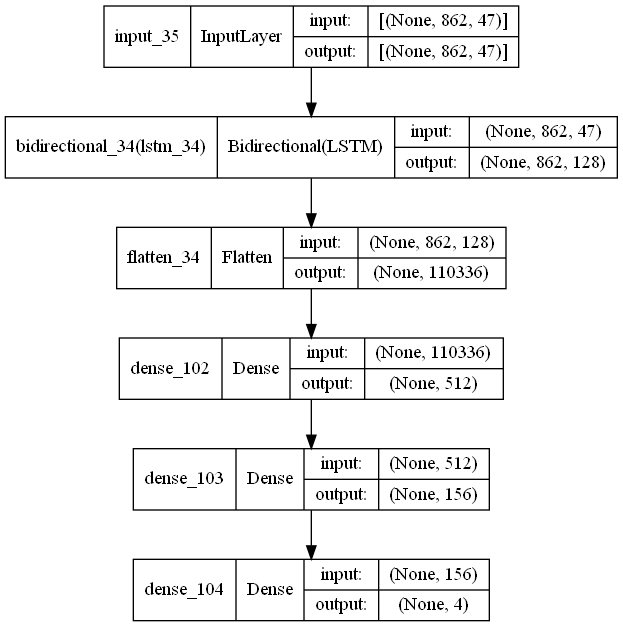

In [81]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.01,recurrent_dropout=0.03))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(512, activation="relu")(x2)
x5 = tf.keras.layers.Dense(156, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="softmax")(x5)
model1_adam =keras.Model(inputs=input1, outputs=[output1])

model1_adam.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
model1_adam.summary()

tf.keras.utils.plot_model(model1_adam, "./model_imgs/model1_adam.png",show_shapes=True)

#### Bi-LSTM with SGD Optimizer

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 862, 47)]         0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 862, 128)         57344     
 onal)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 110336)            0         
                                                                 
 dense_54 (Dense)            (None, 256)               28246272  
                                                                 
 dense_55 (Dense)            (None, 128)               32896     
                                                                 
 dense_56 (Dense)            (None, 4)                 516       
                                                          

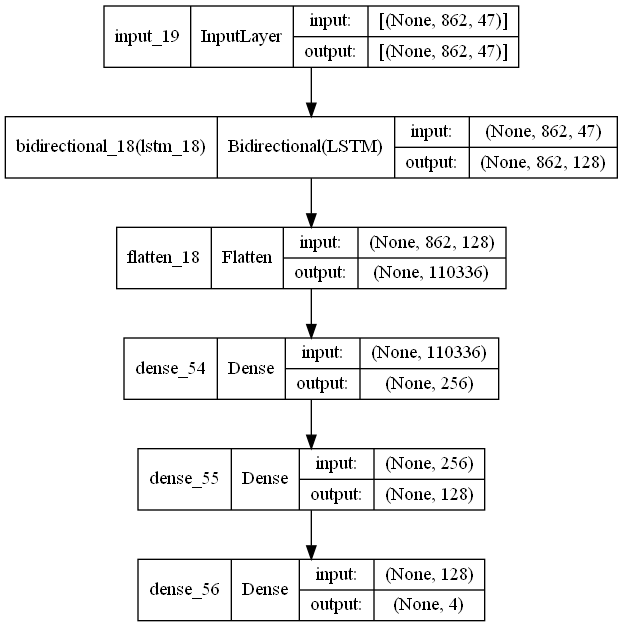

In [48]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.005,recurrent_dropout=0.001))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(256, activation="relu")(x2)
x5 = tf.keras.layers.Dense(128, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="softmax")(x5)
model1_SGD =keras.Model(inputs=input1, outputs=[output1])

model1_SGD.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model1_SGD.summary()

tf.keras.utils.plot_model(model1_SGD, "./model_imgs/model1_SGD.png",show_shapes=True)

#### Training and Testing the Models (Bi-LSTM)

17/17 - 6s - loss: 1.1418 - accuracy: 0.6419 - 6s/epoch - 332ms/step

Test loss: 1.1418242454528809
Test accuracy: 0.6419295072555542


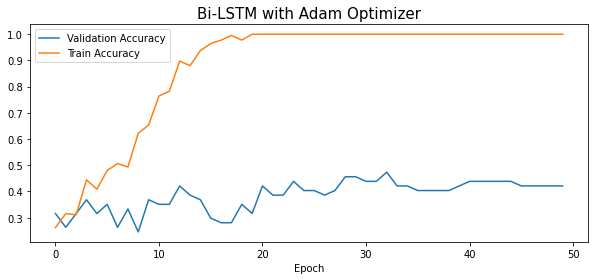

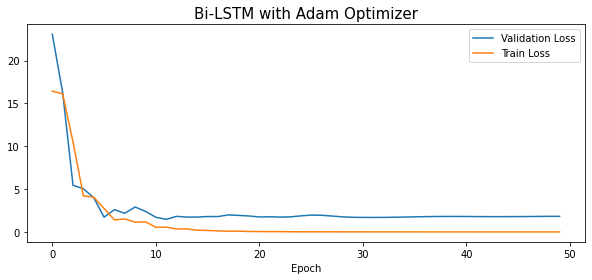

In [82]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=0)

history1_adam = model1_adam.fit(X_train, Y_train_OH,
                    batch_size = 128,
                    epochs = 50,
                    verbose = 0,
                    validation_split = 0.2,callbacks=[checkpoint])

loss1_adam, accuracy1_adam = model1_adam.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\nTest loss:', loss1_adam)
print('Test accuracy:', accuracy1_adam)

dff1_adam = pd.DataFrame(history1_adam.history)

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM with Adam Optimizer',fontsize=15)
plt.plot(range(len(dff1_adam['val_accuracy'])), dff1_adam['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff1_adam['accuracy'])), dff1_adam['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM with Adam Optimizer',fontsize=15)
plt.plot(range(len(dff1_adam['val_loss'])), dff1_adam['val_loss'], label='Validation Loss')
plt.plot(range(len(dff1_adam['loss'])), dff1_adam['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

17/17 - 5s - loss: 1.3722 - accuracy: 0.3210 - 5s/epoch - 308ms/step

Test loss: 1.372235894203186
Test accuracy: 0.3209647536277771


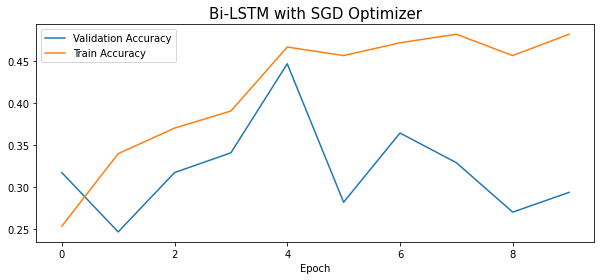

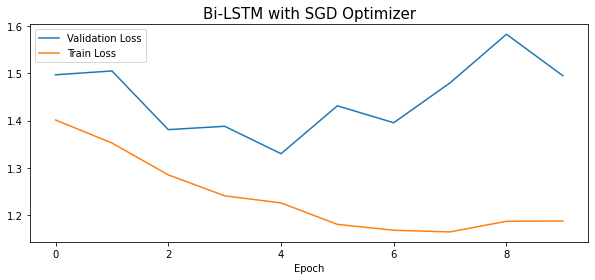

In [50]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=0)

history1_SGD = model1_SGD.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

loss1_SGD, accuracy1_SGD = model1_SGD.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\nTest loss:', loss1_SGD)
print('Test accuracy:', accuracy1_SGD)

dff1_SGD = pd.DataFrame(history1_SGD.history)

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM with SGD Optimizer',fontsize=15)
plt.plot(range(len(dff1_SGD['val_accuracy'])), dff1_SGD['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff1_SGD['accuracy'])), dff1_SGD['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM with SGD Optimizer',fontsize=15)
plt.plot(range(len(dff1_SGD['val_loss'])), dff1_SGD['val_loss'], label='Validation Loss')
plt.plot(range(len(dff1_SGD['loss'])), dff1_SGD['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

### Model 2 : Bi-LSTM + Attention Layer

#### Bi-LSTM + Attention with Adam Optimizer

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 862, 16)     3584        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 flatten_4 (Flatten)            (None, 13792)        0           ['bidirectional_4[0][0]']        
                                                                                                  
 dense_12 (Dense)               (None, 512)          7062016     ['flatten_4[0][0]']        

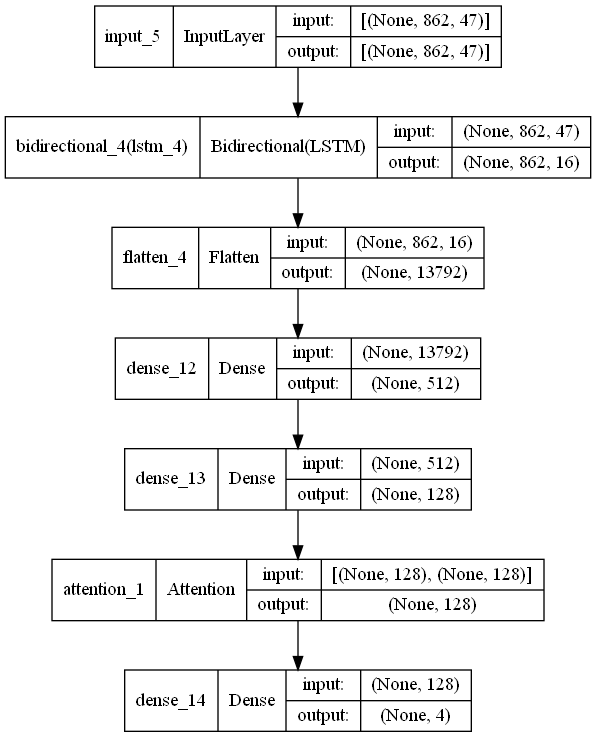

In [19]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
output2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

model2_adam =keras.Model(inputs=input2, outputs=output2)

model2_adam.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
model2_adam.summary()

tf.keras.utils.plot_model(model2_adam, "./model_imgs/model2_adam.png",show_shapes=True)

#### Bi-LSTM + Attention with SGD Optimizer

In [ ]:
input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.01))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
output2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

model2_SGD =keras.Model(inputs=input2, outputs=output2)

model2_SGD.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model2_SGD.summary()

tf.keras.utils.plot_model(model2_SGD, "./model_imgs/model2_SGD.png",show_shapes=True)

#### Training and Testing the Models (Bi-LSTM + Attention Layer)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=0)

history2_adam = model2_adam.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

loss2_adam, accuracy2_adam = model2_adam.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\nTest loss:', loss2_adam)
print('Test accuracy:', accuracy2_adam)

dff2_adam = pd.DataFrame(history2_adam.history)

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM + Attention with Adam Optimizer',fontsize=15)
plt.plot(range(len(dff2_adam['val_accuracy'])), dff2_adam['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff2_adam['accuracy'])), dff2_adam['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM + Attention with Adam Optimizer',fontsize=15)
plt.plot(range(len(dff2_adam['val_loss'])), dff2_adam['val_loss'], label='Validation Loss')
plt.plot(range(len(dff2_adam['loss'])), dff2_adam['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=2)

history2_SGD = model2_SGD.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

loss2_SGD, accuracy2_SGD = model2_SGD.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\n\nTest loss:', loss2_SGD)
print('Test accuracy:', accuracy2_SGD)

dff2_SGD = pd.DataFrame(history2_SGD.history)

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM with SGD Optimizer',fontsize=15)
plt.plot(range(len(dff2_SGD['val_accuracy'])), dff2_SGD['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff2_SGD['accuracy'])), dff2_SGD['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-LSTM with SGD Optimizer',fontsize=15)
plt.plot(range(len(dff2_SGD['val_loss'])), dff2_SGD['val_loss'], label='Validation Loss')
plt.plot(range(len(dff2_SGD['loss'])), dff2_SGD['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

### Model 3 : Bi-LSTM + Attention + XGBoost

In [214]:
class BiLSTM_Attention_XGB():

    def __init__(self, n_epochs=10, n_LSTMS=16, dense1=512, dense2=256, n_classes=4, loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001)):
        self.n_LSTMS = n_LSTMS
        self.dense1 = dense1
        self.dense2 = dense2
        self.loss = loss
        self.optimizer = optimizer
        self.n_classes = n_classes
        self.n_epochs = n_epochs


    def fit(self, X_train, Y_train, xgb_model):
        self.xgb_model = xgb_model
        self.X_train = X_train
        self.Y_train = Y_train

        self.OneHot = sklearn.preprocessing.OneHotEncoder()
        self.OneHot.fit(np.reshape(Y_train, (-1,1)))
        self.Y_train_OH = self.OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()

        self._make_biLSTM()

        zz1 = self.model.get_layer(index=1)(self.X_train)
        zz2 = self.model.get_layer(index=2)(zz1)
        train_features_xgb = self.model.get_layer(index=3)(zz2)

        self.xgb_model.fit(np.array(train_features_xgb), self.Y_train)

    
    def _make_biLSTM(self):

        input3 = tf.keras.Input(shape=(862,47))
        z1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.n_LSTMS,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input3)
        z2 = tf.keras.layers.Flatten()(z1)
        z3 = tf.keras.layers.Dense(self.dense1, activation="relu")(z2)
        z5 = tf.keras.layers.Dense(self.dense2, activation="relu")(z3)
        z6 = tf.keras.layers.Attention()([z5,z5])
        output3 = tf.keras.layers.Dense(self.n_classes, activation="softmax")(z6)
        model3 =keras.Model(inputs=[input3], outputs=[output3])

        model3.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        model3.summary()
        self.model = model3

        tf.keras.utils.plot_model(model3, "./model_imgs/model3.png",show_shapes=True)
        
        self.model.fit(x=self.X_train, y=self.Y_train_OH,
                            batch_size = 32,
                            epochs = self.n_epochs,
                            verbose = 0,
                            validation_split = 0.2)

        self.model = model3


    def predict(self, X_test):
        self.X_test = X_test
        zz1 = self.model.get_layer(index=1)(self.X_test)
        zz2 = self.model.get_layer(index=2)(zz1)
        test_features_xgb = self.model.get_layer(index=3)(zz2)
        self.final_preds = self.xgb_model.predict(test_features_xgb)

        return self.final_preds

#### Bi-LSTM + Attention + XGBoost with Adam Optimizer

In [218]:
model3_Adam = BiLSTM_Attention_XGB(n_epochs=10, n_LSTMS=64, optimizer=tf.keras.optimizers.Adam(0.0005))
model3_Adam.fit(X_train, Y_train, xgb_model = XGB())
xgb_preds_Adam = model3_Adam.predict(X)

Model: "model_89"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_91 (InputLayer)          [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_90 (Bidirectiona  (None, 862, 128)    57344       ['input_91[0][0]']               
 l)                                                                                               
                                                                                                  
 flatten_90 (Flatten)           (None, 110336)       0           ['bidirectional_90[0][0]']       
                                                                                                  
 dense_267 (Dense)              (None, 1024)         112985088   ['flatten_90[0][0]']      

#### Bi-LSTM + Attention + XGBoost with SGD Optimizer

In [ ]:
model3_SGD = BiLSTM_Attention_XGB(n_epochs=10, n_LSTMS=64, optimizer=tf.keras.optimizers.SGD(0.0005))
model3_SGD.fit(X_train, Y_train, xgb_model = XGB())
xgb_preds_SGD = model3_SGD.predict(X)

## **Evaluating Bi-LSTM Models**

## **Bi-GRU Models**

### Model 1 : Bi-GRU Model

#### Bi-GRU with Adam Optimizer

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 862, 47)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 862, 128)         57344     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 110336)            0         
                                                                 
 dense_6 (Dense)             (None, 1024)              112985088 
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                           

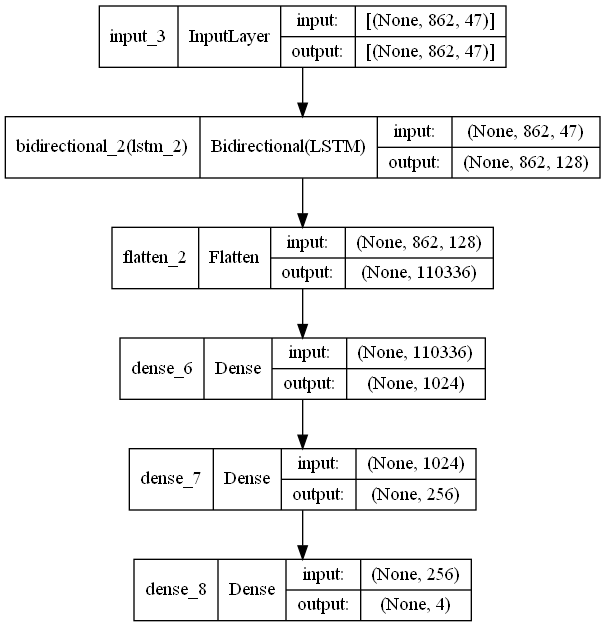

In [ ]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,input_shape=(None,862,47),return_sequences=True, dropout=0.01,recurrent_dropout=0.03))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(1024, activation="relu")(x2)
x5 = tf.keras.layers.Dense(256, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="softmax")(x5)
biGRU_model1_adam =keras.Model(inputs=input1, outputs=[output1])

biGRU_model1_adam.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
biGRU_model1_adam.summary()

tf.keras.utils.plot_model(biGRU_model1_adam, "./model_imgs/biGRU_model1_adam.png",show_shapes=True)

#### Bi-GRU with SGD Optimizer

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 862, 47)]         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 862, 128)         57344     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 110336)            0         
                                                                 
 dense_9 (Dense)             (None, 1024)              112985088 
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                           

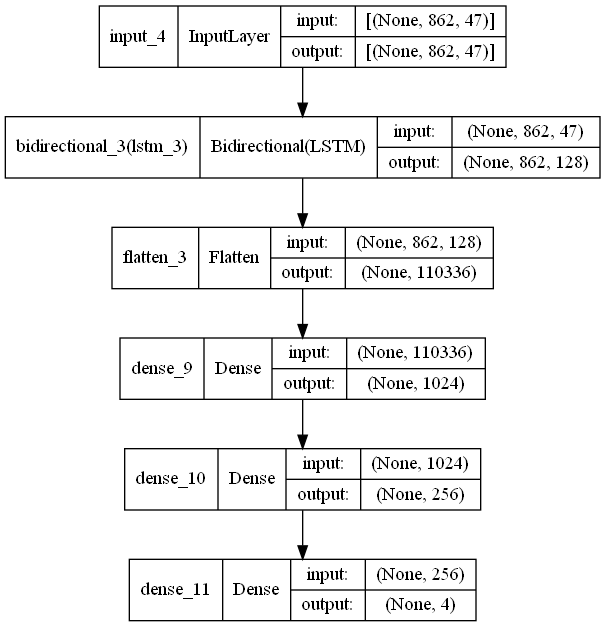

In [ ]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(1024, activation="relu")(x2)
x5 = tf.keras.layers.Dense(256, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="softmax")(x5)
biGRU_model1_SGD =keras.Model(inputs=input1, outputs=[output1])

biGRU_model1_SGD.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
biGRU_model1_SGD.summary()

tf.keras.utils.plot_model(biGRU_model1_SGD, "./model_imgs/biGRU_model1_SGD.png",show_shapes=True)

#### Training and Testing the Models (Bi-GRU)

17/17 - 3s - loss: 2.2646 - accuracy: 0.5733 - 3s/epoch - 204ms/step

Test loss: 2.264589548110962
Test accuracy: 0.573283851146698


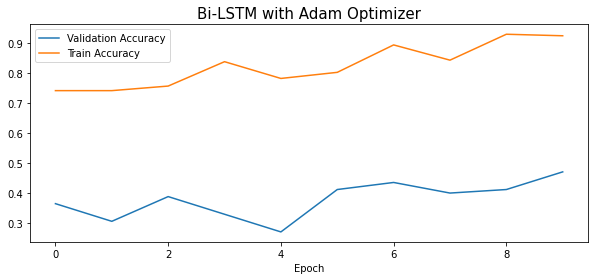

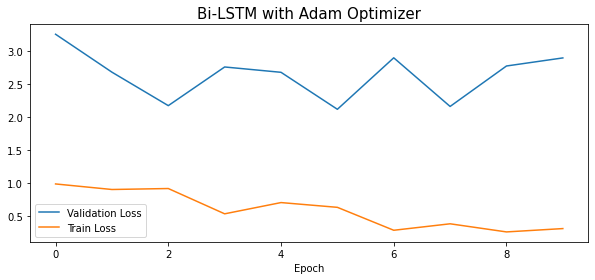

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=0)

biGRU_history1_adam = biGRU_model1_adam.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

biGRU_loss1_adam, biGRU_accuracy1_adam = biGRU_model1_adam.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\nTest loss:', biGRU_loss1_adam)
print('Test accuracy:', biGRU_accuracy1_adam)

biGRU_dff1_adam = pd.DataFrame(biGRU_history1_adam.history)

plt.figure(figsize=(10,4))
plt.title('Bi-GRU with Adam Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff1_adam['val_accuracy'])), biGRU_dff1_adam['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(biGRU_dff1_adam['accuracy'])), biGRU_dff1_adam['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-GRU with Adam Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff1_adam['val_loss'])), biGRU_dff1_adam['val_loss'], label='Validation Loss')
plt.plot(range(len(biGRU_dff1_adam['loss'])), biGRU_dff1_adam['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=0)

biGRU_history1_SGD = biGRU_model1_SGD.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

biGRU_loss1_SGD, biGRU_accuracy1_SGD = biGRU_model1_SGD.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\n\nTest loss:', biGRU_loss1_SGD)
print('Test accuracy:', biGRU_accuracy1_SGD)

biGRU_dff1_SGD = pd.DataFrame(biGRU_history1_SGD.history)

plt.figure(figsize=(10,4))
plt.title('Bi-GRU with SGD Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff1_SGD['val_accuracy'])), biGRU_dff1_SGD['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(biGRU_dff1_SGD['accuracy'])), biGRU_dff1_SGD['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-GRU with SGD Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff1_SGD['val_loss'])), biGRU_dff1_SGD['val_loss'], label='Validation Loss')
plt.plot(range(len(biGRU_dff1_SGD['loss'])), biGRU_dff1_SGD['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

### Model 2 : Bi-GRU + Attention Layer

#### Bi-GRU + Attention with Adam Optimizer

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 862, 16)     3584        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 flatten_4 (Flatten)            (None, 13792)        0           ['bidirectional_4[0][0]']        
                                                                                                  
 dense_12 (Dense)               (None, 512)          7062016     ['flatten_4[0][0]']        

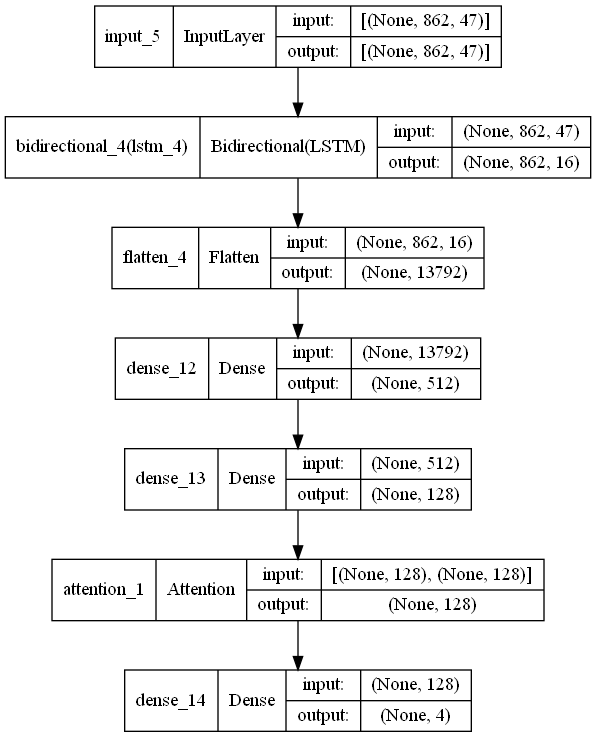

In [ ]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
output2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

biGRU_model2_adam =keras.Model(inputs=input2, outputs=output2)

biGRU_model2_adam.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
biGRU_model2_adam.summary()

tf.keras.utils.plot_model(biGRU_model2_adam, "./model_imgs/biGRU_model2_adam.png",show_shapes=True)

#### Bi-GRU + Attention with SGD Optimizer

In [ ]:
input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.01))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
output2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

biGRU_model2_SGD =keras.Model(inputs=input2, outputs=output2)

biGRU_model2_SGD.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
biGRU_model2_SGD.summary()

tf.keras.utils.plot_model(biGRU_model2_SGD, "./model_imgs/biGRU_model2_SGD.png",show_shapes=True)

#### Training and Testing the Models (Bi-GRU + Attention Layer)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=0)

biGRU_history2_adam = biGRU_model2_adam.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

biGRU_loss2_adam, biGRU_accuracy2_adam = biGRU_model2_adam.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\nTest loss:', biGRU_loss2_adam)
print('Test accuracy:', biGRU_accuracy2_adam)

biGRU_dff2_adam = pd.DataFrame(biGRU_history2_adam.history)

plt.figure(figsize=(10,4))
plt.title('Bi-GRU + Attention with Adam Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff2_adam['val_accuracy'])), biGRU_dff2_adam['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(biGRU_dff2_adam['accuracy'])), biGRU_dff2_adam['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-GRU + Attention with Adam Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff2_adam['val_loss'])), biGRU_dff2_adam['val_loss'], label='Validation Loss')
plt.plot(range(len(biGRU_dff2_adam['loss'])), biGRU_dff2_adam['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=False, verbose=2)

biGRU_history2_SGD = biGRU_model2_SGD.fit(X_train, Y_train_OH,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.3,callbacks=[checkpoint])

biGRU_loss2_SGD, biGRU_accuracy2_SGD = biGRU_model2_SGD.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\n\nTest loss:', biGRU_loss2_SGD)
print('Test accuracy:', biGRU_accuracy2_SGD)

biGRU_dff2_SGD = pd.DataFrame(biGRU_history2_SGD.history)

plt.figure(figsize=(10,4))
plt.title('Bi-GRU + Attention with SGD Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff2_SGD['val_accuracy'])), biGRU_dff2_SGD['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(biGRU_dff2_SGD['accuracy'])), biGRU_dff2_SGD['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Bi-GRU + Attention with SGD Optimizer',fontsize=15)
plt.plot(range(len(biGRU_dff2_SGD['val_loss'])), biGRU_dff2_SGD['val_loss'], label='Validation Loss')
plt.plot(range(len(biGRU_dff2_SGD['loss'])), biGRU_dff2_SGD['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

### Model 3 : Bi-GRU + Attention + XGBoost

In [ ]:
class BiGRU_Attention_XGB():

    def __init__(self, n_epochs=10, n_GRUs=16, dense1=512, dense2=256, n_classes=4, loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001)):
        self.n_GRUs = n_GRUs
        self.dense1 = dense1
        self.dense2 = dense2
        self.loss = loss
        self.optimizer = optimizer
        self.n_classes = n_classes
        self.n_epochs = n_epochs


    def fit(self, X_train, Y_train, xgb_model):
        self.xgb_model = xgb_model
        self.X_train = X_train
        self.Y_train = Y_train

        self.OneHot = sklearn.preprocessing.OneHotEncoder()
        self.OneHot.fit(np.reshape(Y_train, (-1,1)))
        self.Y_train_OH = self.OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()

        self._make_biLSTM()

        zz1 = self.model.get_layer(index=1)(self.X_train)
        zz2 = self.model.get_layer(index=2)(zz1)
        train_features_xgb = self.model.get_layer(index=3)(zz2)

        self.xgb_model.fit(np.array(train_features_xgb), self.Y_train)

    
    def _make_biLSTM(self):

        input3 = tf.keras.Input(shape=(862,47))
        z1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.n_GRUs,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input3)
        z2 = tf.keras.layers.Flatten()(z1)
        z3 = tf.keras.layers.Dense(self.dense1, activation="relu")(z2)
        z5 = tf.keras.layers.Dense(self.dense2, activation="relu")(z3)
        z6 = tf.keras.layers.Attention()([z5,z5])
        output3 = tf.keras.layers.Dense(self.n_classes, activation="softmax")(z6)
        model3 =keras.Model(inputs=[input3], outputs=[output3])

        model3.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        model3.summary()
        self.model = model3

        tf.keras.utils.plot_model(model3, "./model_imgs/model3.png",show_shapes=True)
        
        self.model.fit(x=self.X_train, y=self.Y_train_OH,
                            batch_size = 32,
                            epochs = self.n_epochs,
                            verbose = 0,
                            validation_split = 0.2)

        self.model = model3


    def predict(self, X_test):
        self.X_test = X_test
        zz1 = self.model.get_layer(index=1)(self.X_test)
        zz2 = self.model.get_layer(index=2)(zz1)
        test_features_xgb = self.model.get_layer(index=3)(zz2)
        self.final_preds = self.xgb_model.predict(test_features_xgb)

        return self.final_preds

#### Bi-GRU + Attention + XGBoost with Adam Optimizer

In [ ]:
biGRU_model3_Adam = BiGRU_Attention_XGB(n_epochs=10, n_GRUs=64, optimizer=tf.keras.optimizers.Adam(0.0005))
biGRU_model3_Adam.fit(X_train, Y_train, xgb_model = XGB())
biGRU_xgb_preds_Adam = biGRU_model3_Adam.predict(X_test)

Model: "model_89"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_91 (InputLayer)          [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_90 (Bidirectiona  (None, 862, 128)    57344       ['input_91[0][0]']               
 l)                                                                                               
                                                                                                  
 flatten_90 (Flatten)           (None, 110336)       0           ['bidirectional_90[0][0]']       
                                                                                                  
 dense_267 (Dense)              (None, 1024)         112985088   ['flatten_90[0][0]']      

#### Bi-GRU + Attention + XGBoost with SGD Optimizer

In [ ]:
biGRU_model3_SGD = BiLSTM_Attention_XGB(n_epochs=10, n_GRUs=64, optimizer=tf.keras.optimizers.SGD(0.0005))
biGRU_model3_SGD.fit(X_train, Y_train, xgb_model = XGB())
biGRU_xgb_preds_SGD = biGRU_model3_SGD.predict(X)

## **Evaluating Bi-GRU Models**

## **Final Comparison**